In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import custom_model
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import shuffle
import numpy as np
import itertools, os
from tqdm import tqdm

2024-02-16 13:01:35.519426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
model_name = 'enformer'
csv_dir = f'../results/summary_csvs/{model_name}/'
sufficient_cre_df = pd.read_csv(f'{csv_dir}/sufficient_CREs.csv')
pdf_dir = utils.make_dir('pdfs/multiplicity/')
N_iter = 15

In [66]:
multiplicity_dfs = []
for cell, cell_df in sufficient_cre_df.groupby('cell_line'):
    for tile_type, df in cell_df.groupby('tile class'):
        for i, row in df.iterrows():
            result_path = f'../results/multiplicity_test/{model_name}/{cell}/{row["seq_id"]}_tile_start_{row["tile_start"]}_tile_end_{row["tile_end"]}.pickle'
            res = utils.read_pickle(result_path)
            res['best_tss_signal'].insert(0, res['only_tss_pred'])
            v = np.array(res['best_tss_signal']) / res['tss_and_cre_pred'] # normalize by original CRE position 
            one_seq_df = pd.DataFrame(v, columns=['Normalized TSS activity'])
            one_seq_df['cell_line'] = cell
            one_seq_df['tile class'] = tile_type
            one_seq_df['seq_id'] = f"{row['seq_id']}_{row['tile_start']}"
            multiplicity_dfs.append(one_seq_df)
multiplicity_dfs = pd.concat(multiplicity_dfs)

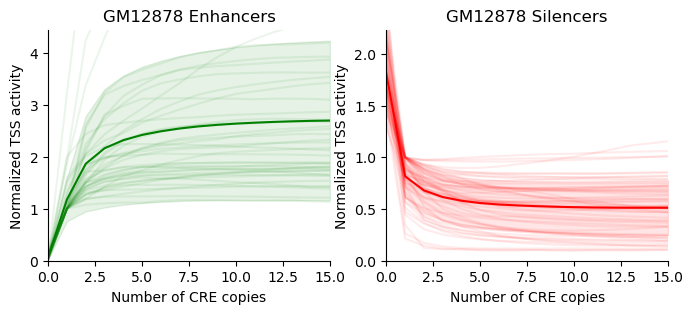

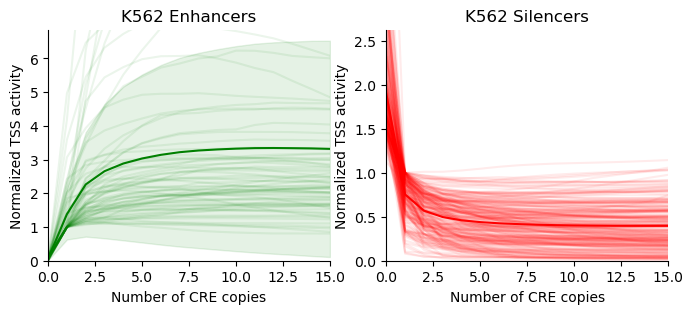

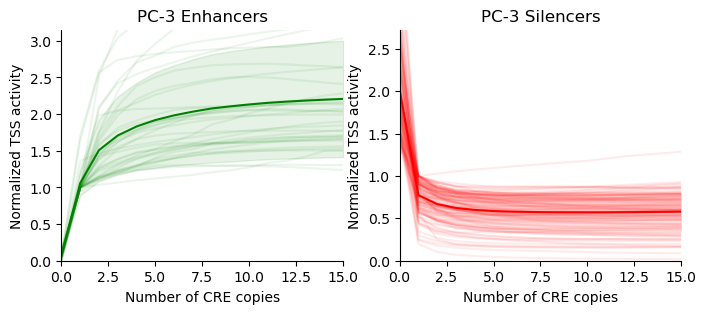

In [68]:
for cell, cell_df in multiplicity_dfs.groupby('cell_line'):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    for tile_type, df in cell_df.groupby('tile class'):
        
        tss_activity = []
        if tile_type == 'Enhancer':
            c = 'g'
            ax = axes[0]
        else:
            c = 'r'
            ax = axes[1]
        for i, one_seq_df in df.groupby('seq_id'):
            
            v = one_seq_df['Normalized TSS activity'].values
            ax.plot(v, alpha=0.08, color=c)
            tss_activity.append(v)
        mean_tss = np.array(tss_activity).mean(axis=0)
        std_tss = np.array(tss_activity).std(axis=0)

        ax.plot(mean_tss, color=c)
        if cell== 'K562' and tile_type=='Silencer':
            ax.fill_between(range(mean_tss.shape[0]), mean_tss-std_tss, mean_tss+std_tss, color=c, alpha=0.005)
        else:
            ax.fill_between(range(mean_tss.shape[0]), mean_tss-std_tss, mean_tss+std_tss, color=c, alpha=0.1)
        ax.set_ylim(0, max((mean_tss+std_tss)*1.05))
        # plt.ylim(0, 4)
        ax.set_title(f'{cell} {tile_type}s')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Number of CRE copies', fontsize=10)
        ax.set_ylabel('Normalized TSS activity', fontsize=10)
        ax.set_xlim(0, 15)

    # fig.savefig(f'{pdf_dir}/{cell}_enhancers_silencers.pdf')

